In [1]:
import sys

sys.path.append('C:/Users/nilso/Documents/EPFL/PDM/PDM_PINN/SciANN/DNN_TEST/sys/')

from loss import *
from unet import UNet
from dataloader import *
from BaseModel import BaseModel

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py

import torch.optim as optim
import time
import json

import psutil

import torch.nn.functional as F
from torch.nn.modules.utils import _quadruple

In [2]:
class FD_Solver(nn.Module):
    def __init__(self, dh=5, dt=0.002, c=2200, device='cuda:0', kernel_size=3):
        super(FD_Solver, self).__init__()

        # Parameters of the mesh
        self.dh = dh
        self.dt = dt
        self.c = c
        self.device = device

        self.kernel_size = kernel_size

        self.P = (self.dt ** 2) * (self.c ** 2)/(self.dh ** 2)

        # Kernels filters
        if self.kernel_size == 1:
            # x FD
            self.weight_h = torch.FloatTensor([[[[ 0,  0,  0],[ 1, -2,  1],[ 0,  0,  0]]]]).to(self.device)
            # y FD
            self.weight_v = torch.FloatTensor([[[[ 0,  1,  0],[ 0, -2,  0],[ 0,  1,  0]]]]).to(self.device) 

            self.padding = _quadruple(1)

    def forward(self,inputs):
        """
        inputs : combination of inputs and outputs of the model, shape = (Minibatch,Channels,Width,Height)
        """    

        # TODO : assert length of channels is 4

        self.u_n = inputs[:,-1:,:,:] 
        self.u_n_1 = inputs[:,-2:-1,:,:]

        # Compute derivatives
        if self.kernel_size == 1:

            self.u_dxdx = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_h, stride=1, padding=0, bias=None)
            self.u_dydy = F.conv2d(F.pad(self.u_n, self.padding, mode='circular'), self.weight_v, stride=1, padding=0, bias=None)

        # Next time step computed based on the finite difference method for the wave equation : 
        next_u = self.P * self.u_dxdx + self.P * self.u_dydy + 2 * self.u_n - self.u_n_1

        return next_u

class Model(BaseModel):
    def __init__(self, net, opt=None, sched=None, logger=None, print_progress=True, device='cpu'):
        super().__init__(net, opt, sched, logger, print_progress, device)

    def forward_loss(self, data):
        return

In [9]:
# Data
data_dir = 'Training_Data/Moseley_Homogeneous_Big/'
data_csv = 'Training_Data/Moseley_Homogeneous_Big_Event0000_Continuous_Predictions.csv'
event = 'Event0000'

# Model path
model_name = 'AR_PINN_MSE_E500'
model_type = 'unet'

# Save path 
results_name = f"{model_type}_" + model_name + ".csv"
save_path = 'model_comparison/' + results_name 

errors_name = f"model_comparison/{model_type}_errors_FDM_" + model_name + ".npy"
preds_name = f"model_comparison/{model_type}_preds_FDM_" + model_name + ".npy"
trues_name = f"model_comparison/{model_type}_trues_FDM_" + model_name + ".npy"

net = UNet(in_channels=4,out_channels=1)
model = Model(net, device='cuda:0')
model.net = model.net.to('cuda:0')
model.load(import_path=f'Training/{model_type}/results/{model_name}.pt',map_location='cuda:0')

training_data = dataset(data_dir,data_csv,event)

In [10]:
### FEM Comparison

number_of_timestep_to_predict = 1700
initial_timestep = 0
offset = 300

timestep_to_plot = [0,250,500,1000,1500]

inputs_FDM = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]

fd_solver = FD_Solver(dh=5, c=2500, dt=0.0002, device='cuda:0',kernel_size=1)

preds = np.zeros((len(timestep_to_plot),300,300))
trues = np.zeros((len(timestep_to_plot),300,300))

ts_vec = []
time_vec = []

norms = [] # Error between predicitons and salvus
norms_FDM = []  # Error between predictions and FDM
errors_FDM_salvus = [] # Error between FDM and Salvus

dict_metrics = {} # To store the norms

im = 0
 
for ts in range(number_of_timestep_to_predict):

    inputs_FDM = inputs_FDM.to('cuda:0')

    # FDM 
    FDM = fd_solver(inputs_FDM).detach()
    FDM_pred = FDM[0,0].cpu().numpy()

    # Load Salvus data
    true = cv2.imread(data_dir + f'{event}_{initial_timestep+offset+ts}.tiff',cv2.IMREAD_UNCHANGED)

    # Norm FDM and salvus
    norms.append(0)
    norms_FDM.append(0)
    errors_FDM_salvus.append( np.mean( np.abs( FDM_pred - true ) ) )

    # Update
    inputs_FDM = torch.cat((inputs_FDM,FDM),dim=1)[:,1:,:,:] # Update inputs for the FEM

    if ts in timestep_to_plot:

        print(f"Saving wavefield {ts}")
        preds[im,:,:] = FDM_pred
        trues[im,:,:] = true
        im += 1

errors = preds - trues

dict_metrics = {'ts':ts_vec,'time':time_vec,'norms':norms,'norms_FEM':norms_FDM,'errors_FDM_salvus':errors_FDM_salvus}

for filename, object in zip([errors_name,trues_name,preds_name],[errors,trues,preds]):
    np.save(filename, object) 

Saving wavefield 0
Saving wavefield 250
Saving wavefield 500
Saving wavefield 1000
Saving wavefield 1500


In [8]:
initial_timestep = 0
number_of_timestep_to_predict = 1700

timestep_to_plot = [0,250,500,1000,1500]

offset = 300

# Predictions : 
#   - 1. Update inputs with the predictions made by the neural network, recursive process
#   - 2. Update true FEM values with the FEM predictions

inputs = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]
inputs_FEM = training_data.__getitem__(initial_timestep)['wave_input'].transpose(1, 0)[None]

fem_solver = FEM_Solver(device='cpu')

preds = np.zeros((len(timestep_to_plot),300,300))
trues = np.zeros((len(timestep_to_plot),300,300))
fem_trues = np.zeros((len(timestep_to_plot),300,300))

ts_vec = []
time_vec = []

norms = [] # Error between predicitons and salvus
norms_FEM = []  # Error between predictions and FEM
norms_FEM_salvus = [] # Error between FEM and Salvus

dict_metrics = {} # To store the norms

im = 0

for ts in range(number_of_timestep_to_predict):

    epoch_start_time = time.time()

    # Recursive predictions
    pred = model.net(inputs).detach() # Detach before otherwise graph retained and memory explodes
    pred_model = pred[0,0].numpy()

    # Computation next TS with FEM
    FEM = fem_solver(inputs_FEM).detach()
    FEM_pred = FEM[0,0].numpy()

    # Load Salvus data
    true = cv2.imread(data_dir + f'{event}_{initial_timestep+offset+ts}.tiff',cv2.IMREAD_UNCHANGED)

    if ts in timestep_to_plot:

        print(f"Saving wavefield {ts}")
        preds[im,:,:] = pred_model
        fem_trues[im,:,:] = FEM_pred
        trues[im,:,:] = true
        im += 1

    # Norm predictions model and Salvus
    norms.append( np.linalg.norm( pred_model - true ))

    # Norm predictions model and FEM
    norms_FEM.append( np.linalg.norm( pred_model - FEM_pred ))

    # Norm FEM and salvus
    norms_FEM_salvus.append( np.linalg.norm( FEM_pred - true ))

    # Update inputs
    inputs = torch.cat((inputs,pred),dim=1)[:,1:,:,:] # Update inputs for NN predictions
    inputs_FEM = torch.cat((inputs_FEM,FEM),dim=1)[:,1:,:,:] # Update inputs for the FEM

    # ts and time
    ts_vec.append(ts)
    time_vec.append(0.0002 * ts)

    epoch_end_time = time.time()
    total_epoch_time = np.round(epoch_end_time - epoch_start_time, 2)
    print(f'\nTotal time for the timestep {ts} in seconds {total_epoch_time}')
    print('RAM memory % used:', psutil.virtual_memory()[2])


dict_metrics = {'ts':ts_vec,'time':time_vec,'norms':norms,'norms_FEM':norms_FEM,'norms_FEM_Salvus':norms_FEM_salvus}

pd.DataFrame.from_dict(dict_metrics).to_csv(save_path)

for filename, object in zip([fem_trues_name,trues_name,preds_name],[fem_trues,trues,preds]):
    np.save(filename, object) 

NameError: name 'FEM_Solver' is not defined

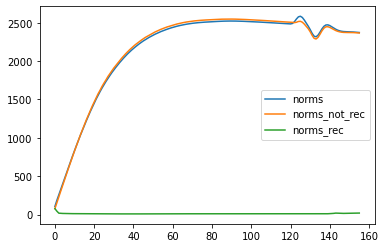

In [84]:
plt.plot(norms,label='norms')
plt.plot(norms_FEM_not_recursive,label='norms_not_rec')
plt.plot(norms_FEM_recursive,label='norms_rec')
plt.legend()

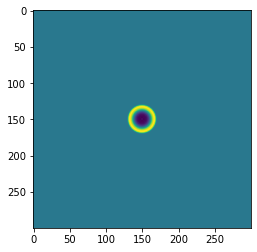

In [51]:
plt.imshow(fem_solver(sample_input[None]).detach().cpu()[0,0])

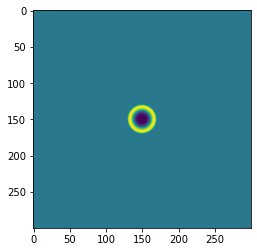

In [52]:
plt.imshow(sample_output[0])

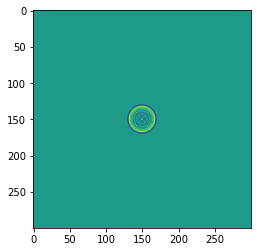

In [53]:
plt.imshow(fem_solver(sample_input[None]).detach().cpu()[0,0]-sample_output[0])